In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
eth=pd.read_csv("ETH.csv",index_col="Date")

In [ ]:
eth

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
"Oct 11, 2021","3,545.06","3,414.93","3,622.53","3,381.43",683.24K,3.81%
"Oct 10, 2021","3,415.03","3,574.52","3,599.18","3,409.22",767.49K,-4.45%
"Oct 09, 2021","3,574.20","3,559.96","3,626.11","3,541.40",464.11K,0.42%
"Oct 08, 2021","3,559.42","3,586.91","3,668.35","3,537.24",681.74K,-0.74%
"Oct 07, 2021","3,586.00","3,575.43","3,650.18","3,473.47",826.29K,0.30%
...,...,...,...,...,...,...
"Mar 14, 2016",12.50,15.07,15.07,11.40,92.18K,-17.05%
"Mar 13, 2016",15.07,12.92,15.07,12.92,1.30K,16.64%
"Mar 12, 2016",12.92,11.95,13.45,11.95,0.83K,8.12%


In [ ]:
eth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2042 entries, Oct 11, 2021 to Mar 10, 2016
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     2042 non-null   object
 1   Open      2042 non-null   object
 2   High      2042 non-null   object
 3   Low       2042 non-null   object
 4   Vol.      2042 non-null   object
 5   Change %  2042 non-null   object
dtypes: object(6)
memory usage: 111.7+ KB


In [ ]:
eth['Price'] = eth['Price'].replace(',','', regex=True)

In [ ]:
eth.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
"Oct 11, 2021",3545.06,"3,414.93","3,622.53","3,381.43",683.24K,3.81%
"Oct 10, 2021",3415.03,"3,574.52","3,599.18","3,409.22",767.49K,-4.45%
"Oct 09, 2021",3574.20,"3,559.96","3,626.11","3,541.40",464.11K,0.42%
"Oct 08, 2021",3559.42,"3,586.91","3,668.35","3,537.24",681.74K,-0.74%
"Oct 07, 2021",3586.00,"3,575.43","3,650.18","3,473.47",826.29K,0.30%


In [ ]:
eth['Price'] = eth['Price'].astype(float, errors = 'raise')

In [ ]:
reversed(eth.index)

In [ ]:
eth.index[::-1]

Index(['Mar 10, 2016', 'Mar 11, 2016', 'Mar 12, 2016', 'Mar 13, 2016',
       'Mar 14, 2016', 'Mar 15, 2016', 'Mar 16, 2016', 'Mar 17, 2016',
       'Mar 18, 2016', 'Mar 19, 2016',
       ...
       'Oct 02, 2021', 'Oct 03, 2021', 'Oct 04, 2021', 'Oct 05, 2021',
       'Oct 06, 2021', 'Oct 07, 2021', 'Oct 08, 2021', 'Oct 09, 2021',
       'Oct 10, 2021', 'Oct 11, 2021'],
      dtype='object', name='Date', length=2042)

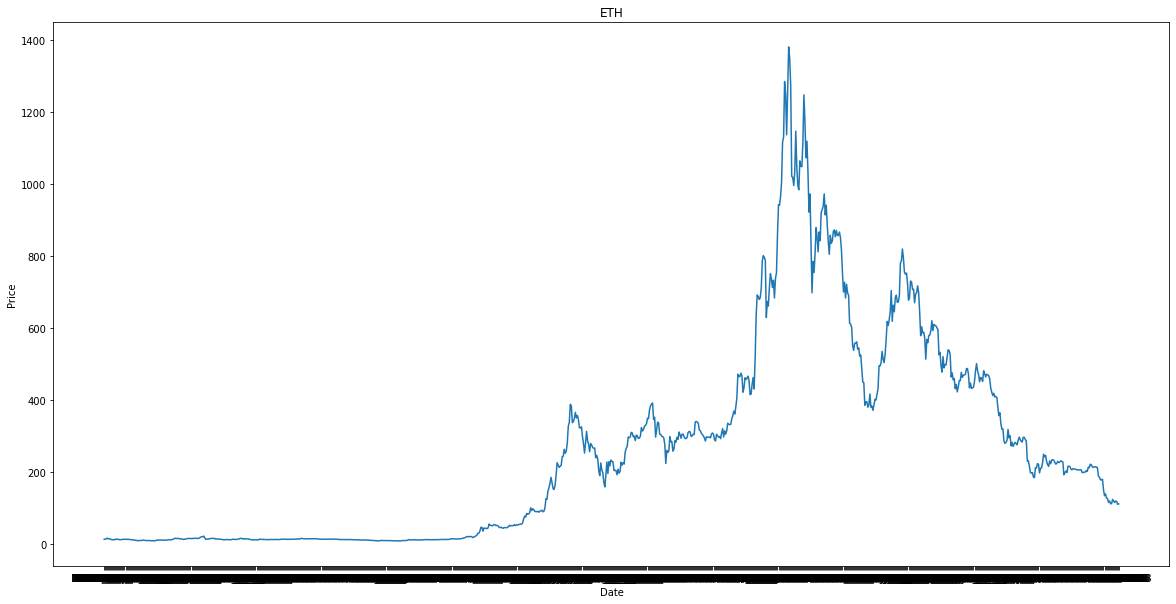

In [ ]:
#eth_trace = go.Scatter(x=eth.index[::-1], y=eth['Price'][::-1], name= 'Price')
#py.iplot([eth_trace])
pyplot.figure(figsize=(20,10))
pyplot.plot(eth.index[::-1][:1000],eth['Price'][::-1][:1000])
pyplot.xlabel("Date")  
pyplot.ylabel("Price") 
pyplot.title("ETH")  
pyplot.show()

In [ ]:
#eth_trace = go.Scatter(x=eth.index[::-1], y=eth['Price'][::-1], name= 'Price')
#py.iplot([eth_trace])
from sklearn.preprocessing import MinMaxScaler
values = eth['Price'][::-1].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
train_size = int(len(scaled) * 0.65)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))
print(train)
print(scaled)

1327 715
[[0.00121363]
 [0.00126169]
 [0.0014948 ]
 ...
 [0.04200593]
 [0.04155652]
 [0.04262115]]
[[0.00121363]
 [0.00126169]
 [0.0014948 ]
 ...
 [0.8573496 ]
 [0.8190975 ]
 [0.8503466 ]]


In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX,trainY)

1326
714
[[0.00121363]
 [0.00126169]
 [0.0014948 ]
 ...
 [0.03701684]
 [0.04200593]
 [0.04155652]] [0.00126169 0.0014948  0.0020115  ... 0.04200593 0.04155652 0.04262115]


In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(150, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

[[0.04442409]
 [0.04645061]
 [0.04478872]
 [0.04458564]
 [0.04475871]
 [0.04473333]
 [0.04443102]
 [0.04538879]
 [0.0460397 ]
 [0.04664222]
 [0.04564038]
 [0.04496873]
 [0.04518337]
 [0.04611358]
 [0.04521338]
 [0.04565192]
 [0.04596815]
 [0.0452503 ]
 [0.04408257]
 [0.04459718]
 [0.04500335]
 [0.04369262]
 [0.04313657]
 [0.04287587]
 [0.03976231]
 [0.03707455]
 [0.03768759]
 [0.03496862]
 [0.03617585]
 [0.03656988]
 [0.03774291]
 [0.03736724]
 [0.03816932]
 [0.03757005]
 [0.03736032]
 [0.03686484]
 [0.03661828]
 [0.03615052]
 [0.03681875]
 [0.03686484]
 [0.03672428]
 [0.03739028]
 [0.03663211]
 [0.03616664]
 [0.0356252 ]
 [0.0359754 ]
 [0.03595928]
 [0.03528423]
 [0.03539942]
 [0.03315368]
 [0.03068559]
 [0.03318592]
 [0.03214973]
 [0.0322142 ]
 [0.03196324]
 [0.03301781]
 [0.03207145]
 [0.03206454]
 [0.03141762]
 [0.03157646]
 [0.03168697]
 [0.03213362]
 [0.03352675]
 [0.03293491]
 [0.03233163]
 [0.03268622]
 [0.03186654]
 [0.03349682]
 [0.03351063]
 [0.03380082]
 [0.03575653]
 [0.03

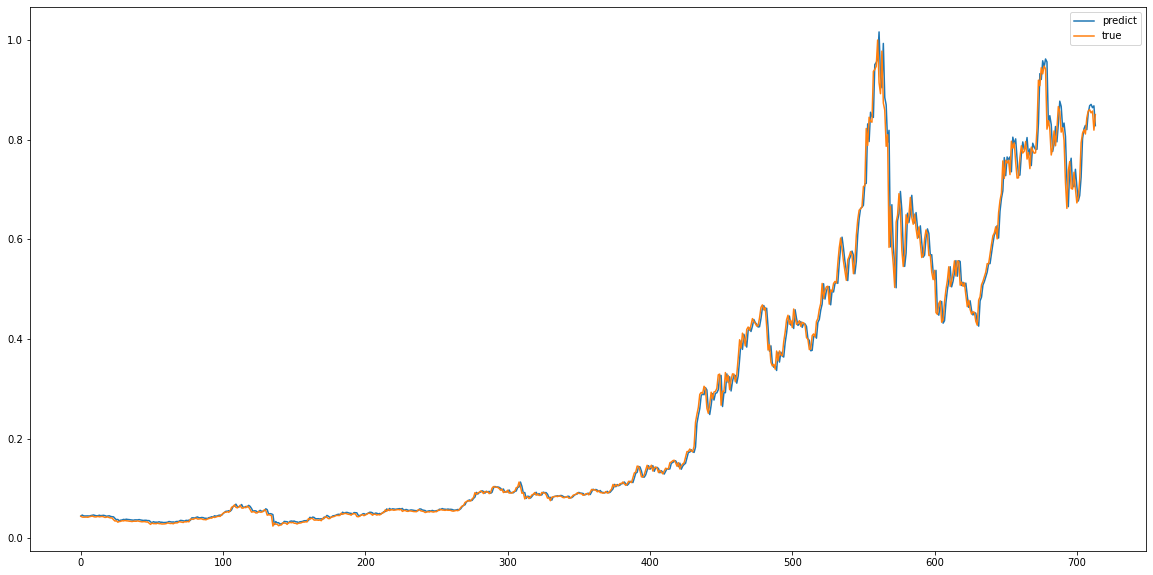

In [ ]:
yhat = model.predict(testX)
print(yhat)
pyplot.figure(figsize=(20,10))
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [ ]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [ ]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 96.505


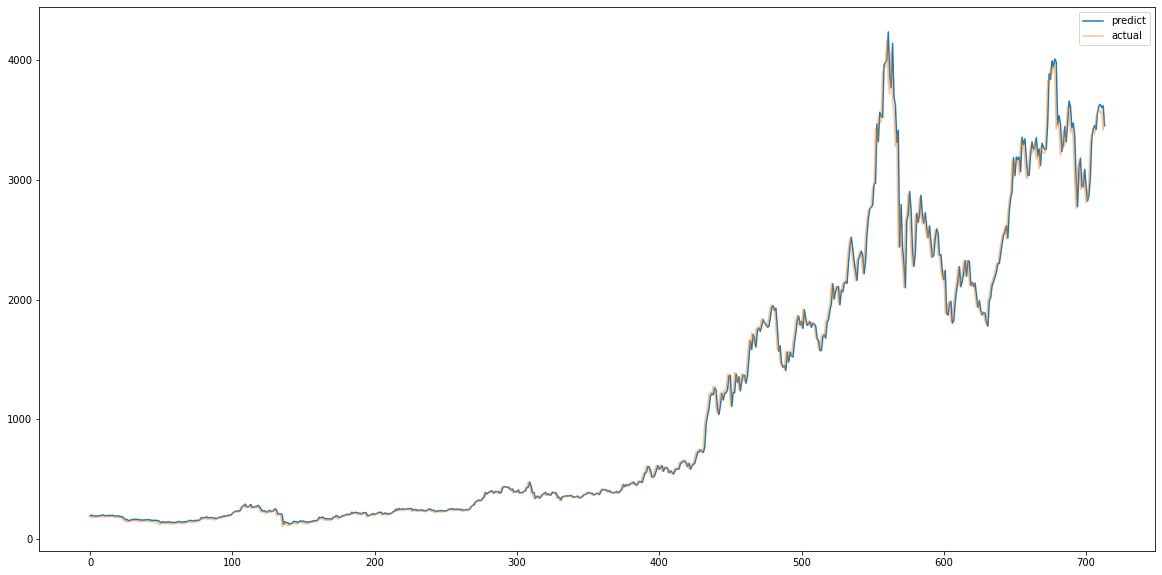

In [ ]:
pyplot.figure(figsize=(20,10))
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [ ]:
predictDates = eth.tail(len(testX)).index

In [ ]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [ ]:
yhat_inverse

array([[ 191.55219],
       [ 199.9847 ],
       [ 193.06944],
       [ 192.2244 ],
       [ 192.94458],
       [ 192.83896],
       [ 191.581  ],
       [ 195.56638],
       [ 198.27487],
       [ 200.78198],
       [ 196.61325],
       [ 193.81848],
       [ 194.71161],
       [ 198.58226],
       [ 194.83647],
       [ 196.66125],
       [ 197.97713],
       [ 194.99013],
       [ 190.13109],
       [ 192.27242],
       [ 193.96254],
       [ 188.50847],
       [ 186.19472],
       [ 185.10991],
       [ 172.15413],
       [ 160.97017],
       [ 163.52107],
       [ 152.20723],
       [ 157.23062],
       [ 158.8702 ],
       [ 163.75124],
       [ 162.18806],
       [ 165.52557],
       [ 163.03198],
       [ 162.15927],
       [ 160.09755],
       [ 159.07156],
       [ 157.12517],
       [ 159.90578],
       [ 160.09755],
       [ 159.51265],
       [ 162.28395],
       [ 159.1291 ],
       [ 157.19226],
       [ 154.93929],
       [ 156.39653],
       [ 156.32944],
       [ 153.

In [ ]:
model.save("model.h5")

In [ ]:
from numpy import loadtxt
from keras.models import load_model
 
# load model
model1 = load_model('model.h5')
# summarize model.
model1.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 150)               91200     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#from 11th OCT 2021 to xth Date
model1.predict([[[0.8503466]]])

array([[0.86056674]], dtype=float32)

In [ ]:
yhat1=[]
prev=0.8503466
#50 means next 50 days from 11th OCT 2021
for i in range(0,50):
  x=model1.predict([[[prev]]])
  yhat1.append(x[0][0])
  prev=x[0][0].item()


In [ ]:
print(yhat1)

[0.86056674, 0.8711903, 0.88223577, 0.89372265, 0.9056709, 0.9181011, 0.93103504, 0.9444951, 0.9585043, 0.9730866, 0.9882667, 1.0040698, 1.0205212, 1.0376468, 1.055473, 1.0740252, 1.0933297, 1.1134124, 1.1342963, 1.1560054, 1.1785612, 1.2019827, 1.2262856, 1.2514839, 1.2775862, 1.3045964, 1.3325124, 1.3613263, 1.3910228, 1.4215773, 1.4529574, 1.4851198, 1.518011, 1.5515682, 1.585715, 1.6203656, 1.6554222, 1.6907771, 1.7263132, 1.7619059, 1.7974243, 1.832732, 1.8676922, 1.9021676, 1.9360231, 1.9691312, 2.001372, 2.0326347, 2.0628207, 2.091846]


In [ ]:
yhat1=np.array(yhat1)

In [ ]:
yhat1_inverse = scaler.inverse_transform(yhat1.reshape(-1, 1))

In [ ]:
yhat1_inverse
#(11th OCT to apna date)

array([[3587.5867],
       [3631.7922],
       [3677.7532],
       [3725.551 ],
       [3775.2686],
       [3826.9917],
       [3880.811 ],
       [3936.8193],
       [3995.1128],
       [4055.7908],
       [4118.9565],
       [4184.7144],
       [4253.17  ],
       [4324.4307],
       [4398.607 ],
       [4475.804 ],
       [4556.132 ],
       [4639.6978],
       [4726.597 ],
       [4816.9307],
       [4910.787 ],
       [5008.246 ],
       [5109.372 ],
       [5214.224 ],
       [5322.838 ],
       [5435.2295],
       [5551.39  ],
       [5671.287 ],
       [5794.8564],
       [5921.9966],
       [6052.5713],
       [6186.402 ],
       [6323.2646],
       [6462.8984],
       [6604.987 ],
       [6749.1704],
       [6895.0435],
       [7042.158 ],
       [7190.027 ],
       [7338.131 ],
       [7485.926 ],
       [7632.8438],
       [7778.316 ],
       [7921.7705],
       [8062.6465],
       [8200.412 ],
       [8334.568 ],
       [8464.654 ],
       [8590.261 ],
       [8711.037 ]],

In [ ]:
print(testX)